# Set up

In [1]:
import pandas as pd
import numpy as np
import json
import pickle

# Load training set

In [2]:
train_set = pd.read_pickle('train_set.pkl')
train_set

,claim,claimant,date,label,related_articles,id
9389,While arguing over President Reagan’s 1981 tax...,Sarah Sanders,2017-10-31,1,"[34218, 55700, 18736, 39031, 34219, 34220]",10354
1861,"Recently Rick Scott ""closed 30 women’s health ...",Lois Frankel,2014-09-12,0,"[73190, 76997, 38841, 77415, 77303, 9280, 8332...",2053
11035,Says Target installed urinals in a women’s bat...,Facebook posts,2016-04-22,0,"[9619, 22197]",12160
12221,"Says ""combined doses of vaccines"" have never b...",Facebook posts,2019-04-15,0,"[57163, 31528, 40908, 31536, 68904, 44601]",13458
11354,: The AMBER Alert system has been discontinu...,,2013-10-13,0,"[103978, 121475, 121849]",12504
...,...,...,...,...,...,...
2910,Health insurance costs for Floridians are up 3...,Republican Party of Florida,2014-09-23,1,"[9581, 89571, 7836, 7945, 7949, 77360, 83491, ...",3208
6096,"A photograph captures Harriet Tubman as a ""Gun...",,2019-03-25,0,"[125108, 125968, 126005]",6701
10446,"ISIS leader Abu Bakr al Baghdadi was ""released...",Jeanine Pirro,2014-06-14,0,"[80115, 93998, 5968, 175, 91475, 8710, 89881, ...",11514
5414,"""The board of a nonprofit organization on whic...",Tennessee Republican Party,2008-02-25,1,"[96453, 71123, 61, 69968, 96477]",5966


# Load test data

In [3]:
test_set = pd.read_pickle('test_set.pkl')

# Combine claim and claimant

In [4]:
train_set["combined"] = train_set["claim"].map(str) + ' ' + train_set["claimant"]

In [5]:
df = pd.DataFrame(train_set, columns=['combined', 'label'])
df

,combined,label
9389,While arguing over President Reagan’s 1981 tax...,1
1861,"Recently Rick Scott ""closed 30 women’s health ...",0
11035,Says Target installed urinals in a women’s bat...,0
12221,"Says ""combined doses of vaccines"" have never b...",0
11354,: The AMBER Alert system has been discontinu...,0
...,...,...
2910,Health insurance costs for Floridians are up 3...,1
6096,"A photograph captures Harriet Tubman as a ""Gun...",0
10446,"ISIS leader Abu Bakr al Baghdadi was ""released...",0
5414,"""The board of a nonprofit organization on whic...",1


In [6]:
df.iloc[2,0]

'Says Target installed urinals in a women’s bathroom to "accommodate the ones who have giblets." Facebook posts'

# Train model

In [7]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

/home/alice/projects/fake-news-ai/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alice/projects/fake-news-ai/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alice/projects/fake-news-ai/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.en

In [8]:
X_train = df.combined
y_train = df.label
X_test = test_set.claim
y_test = test_set.label

In [9]:
sm = SMOTE()
cv = CountVectorizer()
tf = TfidfVectorizer()

In [10]:
# Create classifiers
nb = MultinomialNB()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = LinearSVC()
rg = RidgeClassifier()

In [11]:
pipeline1 = Pipeline([('cv', cv), ('nb', nb)])

In [12]:
pipeline1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [13]:
y_pred = pipeline1.predict(X_test)

In [14]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='macro')))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 59.56%

F1 Score: 0.430846

Confusion Matrix:
 [[910 532  12]
 [388 937   9]
 [131 186   6]]


Normalized Confusion Matrix
[[0.29251045 0.17100611 0.00385728]
 [0.12471874 0.30118933 0.00289296]
 [0.04210865 0.05978785 0.00192864]]


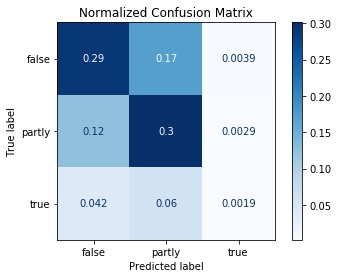

In [15]:
title = "Normalized Confusion Matrix"
disp = plot_confusion_matrix(pipeline1, X_test, y_test, 
                             display_labels=['false', 'partly', 'true'], 
                             cmap=plt.cm.Blues, 
                             normalize='all')
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)

In [16]:
# with open("../models/combined_claim_claimant_oversampled.pkl", 'wb') as f:
#     pickle.dump(pipeline, f)

In [17]:
pipeline2 = Pipeline([('cv', cv), ('sm', sm), ('nb', nb)])

In [18]:
pipeline2.fit(X_train, y_train)

/home/alice/projects/fake-news-ai/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('nb',
                 Mu

In [19]:
y_pred = pipeline2.predict(X_test)

In [20]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='macro')))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 57.67%

F1 Score: 0.472123

Confusion Matrix:
 [[822 523 109]
 [345 920  69]
 [104 167  52]]


Normalized Confusion Matrix
[[0.26422372 0.16811315 0.03503697]
 [0.11089682 0.29572485 0.02217936]
 [0.03342977 0.05368049 0.01671488]]


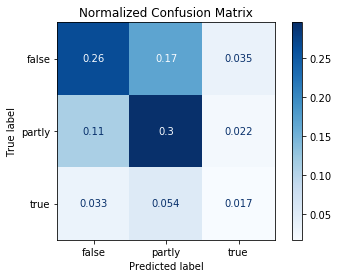

In [21]:
title = "Normalized Confusion Matrix"
disp = plot_confusion_matrix(pipeline1, X_test, y_test, 
                             display_labels=['false', 'partly', 'true'], 
                             cmap=plt.cm.Blues,
                             normalize='all')
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)